# Connect to the cluster

In [1]:
import socket
on_io = socket.gethostname() == 'io'
if on_io and 0:
    import hpc05, hpc05_monitor
    client = hpc05.connect.start_remote_and_connect(200, folder='~/two_dim_majoranas')[0]
    max_usage_task = hpc05_monitor.start(client)
else:
    # No not connect to the cluster in CI for example.
    client = None

## Numerics imports

In [2]:
from functools import partial
from copy import copy
import numpy as np
import adaptive
import sns_system, kwant, spectrum
adaptive.notebook_extension()

import pathlib
pathlib.Path('thesis_report/figures').mkdir(parents=True, exist_ok=True) 

## Plotting imports

In [3]:
import matplotlib
matplotlib.use('agg')

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

class HistogramNormalize(matplotlib.colors.Normalize):
    def __init__(self, data, vmin=None, vmax=None, mixing_degree=1):
        self.mixing_degree = mixing_degree
        if vmin is not None:
            data = data[data >= vmin]
        if vmax is not None:
            data = data[data <= vmax]

        self.sorted_data = np.sort(data.flatten())
        matplotlib.colors.Normalize.__init__(self, vmin, vmax)

    def __call__(self, value, clip=None):
        hist_norm = np.ma.masked_array(np.searchsorted(self.sorted_data, value) /
                                       len(self.sorted_data))
        linear_norm = super().__call__(value, clip)
        return self.mixing_degree * hist_norm + (1 - self.mixing_degree) * linear_norm

golden_mean = (np.sqrt(5) - 1) / 2  # Aesthetic ratio
inches_per_pt = 1.0 / 72.27  # Convert pt to inches
fig_width_pt = 6.2 / inches_per_pt  # Columnwidth
fig_width = fig_width_pt * inches_per_pt
fig_height = fig_width * golden_mean  # height in inches
fig_size = [fig_width, fig_height]

params = {
          'backend': 'ps',
          'axes.labelsize': 13,
          'font.size': 13,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          'figure.figsize': fig_size,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Roman',
          'legend.frameon': True,
          'savefig.dpi': 100 if on_io else 300,
         }

plt.rcParams.update(params)
plt.rc('text.latex', preamble=[r'\usepackage{color}', r'\usepackage{bm}', r'\usepackage{xfrac}'])

## Parameter and system definitions

In [4]:
import scipy.constants
import cmath

constants = dict(
    m_eff=0.02 * scipy.constants.m_e / (scipy.constants.eV * 1e-3) / 1e18,  # effective mass in kg, 
    hbar=scipy.constants.hbar / (scipy.constants.eV * 1e-3),
    e = scipy.constants.e,
    current_unit=scipy.constants.k * scipy.constants.e / scipy.constants.hbar * 1e9,  # to get nA
    mu_B=scipy.constants.physical_constants['Bohr magneton'][0] / (scipy.constants.eV * 1e-3),
    k=scipy.constants.k / (scipy.constants.eV * 1e-3),
    exp=cmath.exp,
    cos=cmath.cos,
    sin=cmath.sin
   )

params_raw= dict(g_factor_middle=26, g_factor_left=0, g_factor_right=0,
                 mu=10,
                 alpha_middle=20, alpha_left=0, alpha_right=0,
                 Delta_left=1, Delta_right=1,
                 B_x=0,
                 B_y=0,
                 B_z=0,
                 phase=np.pi,
                 T=0.0,
                 V=0)

default_params = dict(**constants,
              **params_raw)

default_syst_pars = dict(
    L_m=200,
    L_x=1300,
    L_sc_up=200,
    L_sc_down=200,
    z_x=1300,
    z_y=0,
    a=10,
    shape='parallel_curve',
    transverse_soi=True,
    mu_from_bottom_of_spin_orbit_bands=True,
    k_x_in_sc=True,
    wraparound=True,
    current=False,
    ns_junction=False)

# Figure 1. Kwant system

In [5]:
syst_pars_cosmetic = dict(
    L_m = 240,
    L_x = 1*840,
    L_sc_up = 120,
    L_sc_down = 120,
    z_x = 840,
    z_y = 160,
    a   = 40,
    shape = 'sawtooth',
    transverse_soi = True,
    mu_from_bottom_of_spin_orbit_bands = True,
    k_x_in_sc = True,
    wraparound = False,
    current = False,
    ns_junction=False)

syst_1, site_colors_1, hopping = sns_system.make_system(**dict(syst_pars_cosmetic, shape='sawtooth'))
syst_2, site_colors_2, hopping = sns_system.make_system(**dict(syst_pars_cosmetic, shape='parallel_curve', L_sc_up=160))
syst_3, site_colors_3, hopping = sns_system.make_system(**dict(syst_pars_cosmetic, shape=None, z_y=0, L_sc_up = 320, L_sc_down = 280))

coloring =  {'middle_interior' : 'xkcd:cerulean',
             'middle_barrier' : 'black',
             'bottom_superconductor' : 'xkcd:amber',
             'top_superconductor' : 'xkcd:pumpkin',
             'top_cut' : 'red',
             'bottom_cut' : 'blue'}

# for k,v in site_colors.items():
#     if site_colors.get(k) is not None:
site_colors_1 = {k : coloring[v] for k, v in site_colors_1.items()}
site_colors_2 = {k : coloring[v] for k, v in site_colors_2.items()}
site_colors_3 = {k : coloring[v] for k, v in site_colors_3.items()}
#         site_colors_1[k] = coloring[v]
#         site_colors_2[k] = coloring[v]

/home/tinkerer/thesis_repo/two_dim_majoranas/sns_system.py:414: RuntimeWarning: fill(): None of the starting sites is in the desired shape
  edge_sites_new = syst.fill(template_edge, edge_shape, pos)
/home/tinkerer/thesis_repo/two_dim_majoranas/sns_system.py:414: RuntimeWarning: fill(): The target builder already contains all starting sites.
  edge_sites_new = syst.fill(template_edge, edge_shape, pos)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


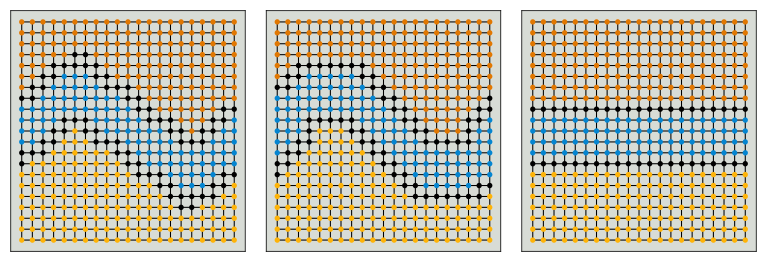

In [6]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(1.75*fig_width, 1*fig_height))

ax1, ax2, ax3 = axs
ax1.tick_params(labelbottom=False, bottom=False, left=False, labelleft=False)
ax2.tick_params(labelbottom=False, bottom=False, left=False, labelleft=False)
ax3.tick_params(labelbottom=False, bottom=False, left=False, labelleft=False)
ax1.set_facecolor('xkcd:light grey')
ax2.set_facecolor('xkcd:light grey')
ax3.set_facecolor('xkcd:light grey')
kwant.plot(syst_1, site_color=sns_system.site_color_function(site_colors_1, syst_1), ax=ax1);
kwant.plot(syst_2, site_color=sns_system.site_color_function(site_colors_2, syst_2), ax=ax2);
kwant.plot(syst_3, site_color=sns_system.site_color_function(site_colors_3, syst_3), ax=ax3);
plt.tight_layout()
plt.savefig("thesis_report/figures/kwant_system.pdf", bbox='tight')

# Figure 2. E_gap(z_y)

### System size examples

In [8]:
# def deltas(syst):
#     return [np.abs(syst.hamiltonian(i, i, params=dict(default_params, k_x=0))[1, 0])
#             for i, site in enumerate(syst.sites)]

# z_ys_plots = [10, 50, 100, 200, 300]
# for ratio in [4, 8, 16]:
#     fig, axs = plt.subplots(ncols=len(z_ys_plots))
#     for (ax, z_y) in zip(axs.reshape(-1), z_ys_plots):
#         z_x = L_x = z_y * ratio
#         syst_pars = dict(default_syst_pars, z_y=z_y, z_x=z_x, L_x=L_x, shape='sawtooth')
#         syst, site_parts, _ = sns_system.make_system(**syst_pars)

#         Deltas = deltas(syst)
#         Deltas = [1 if x == 0 else np.nan for x in Deltas]
#         gray_r = matplotlib.cm.gray_r
#         gray_r.set_bad('#e0e0e0')
#         ax.set_title(f'{z_y} nm', fontsize=10)
#         ax.set_xticks([])
#         ax.set_yticks([])
#         fig.suptitle(f'ratio {ratio}')
#         kwant.plotter.map(syst, Deltas, cmap=gray_r, ax=ax, colorbar=False);
#     plt.show()

### Define learners

In [9]:
import operator
from adaptive.learner.learner1D import curvature_loss_function
B = 1
def gap_wrapper(k_x, z_y, ratio=4, syst_pars=copy(default_syst_pars), params=copy(default_params), nbands=10):
    import numpy as np
    import sns_system, spectrum
    z_x = z_y * ratio
    params = dict(params, k_x=k_x, mu=20, B_x=1)
    syst_pars = dict(syst_pars, z_y=z_y, z_x=z_x, L_x=z_x, a=5, shape='sawtooth')
    syst_at_k, _, _ = sns_system.make_system(**syst_pars)
    Es = spectrum.calc_spectrum(syst_at_k, params, k=nbands)[0]
    return dict(E_min=np.abs(Es).min(), energies=Es)

def fnames(learner):
    val = learner.function.keywords  # because functools.partial
    fname = '__'.join([f'{k}_{v}.pickle' for k, v in val.items()])
    return 'data/z_y_vs_E_gap/' + fname

Learner = adaptive.make_datasaver(adaptive.Learner1D, arg_picker=operator.itemgetter('E_min'))
kwargs = dict(bounds=[-np.pi, np.pi], loss_per_interval=curvature_loss_function())
z_ys = np.arange(10, 405, 5)
combos = {'z_y': z_ys, 'ratio': [4, 8, 16]}
learner = adaptive.BalancingLearner.from_product(gap_wrapper, Learner, kwargs, combos)
learner.load(fnames)

In [11]:
runner = adaptive.Runner(learner, lambda l: l.loss() < 0.01, executor=client)
runner.live_info()

In [12]:
# saving_task = runner.start_periodic_saving(dict(fname=fnames), 600)

In [ ]:
# runner.task.print_stack()

In [14]:
# Plot the abs(min(bands(k)))
# learner.plot()

In [15]:
# Plot the entire band structure
# def plot_bands(l):
#     import holoviews as hv
#     if l.data:
#         ks, vals = zip(*l.extra_data.items())
#         Es = np.array([x['energies'] for x in vals])
#         E_min = min(l.data.values())
#         scatter = hv.Overlay([hv.Scatter((ks, E)).opts(style=dict(color='k')) for E in Es.T])
#         return scatter * hv.HLine(E_min)
#     else:
#         return hv.Overlay(hv.Scatter([]))

# learner.plot(plotter=plot_bands)

:DynamicMap   [z_y,ratio]
   :Overlay
      .Scatter.I    :Scatter   [x]   (y)
      .Scatter.II   :Scatter   [x]   (y)
      .Scatter.III  :Scatter   [x]   (y)
      .Scatter.IV   :Scatter   [x]   (y)
      .Scatter.V    :Scatter   [x]   (y)
      .Scatter.VI   :Scatter   [x]   (y)
      .Scatter.VII  :Scatter   [x]   (y)
      .Scatter.VIII :Scatter   [x]   (y)
      .Scatter.IX   :Scatter   [x]   (y)
      .Scatter.X    :Scatter   [x]   (y)
      .HLine.I      :HLine   [x,y]

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


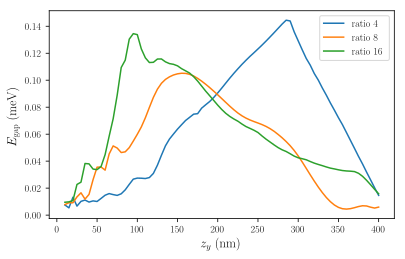

In [16]:
from collections import defaultdict
d = defaultdict(dict)
for cdim, l in zip(learner._cdims_default, learner.learners):
    d[cdim['ratio']][cdim['z_y']] = l

def get_mins(learners_dict):
    learners = learners_dict.values()
    return [min(l.data.values()) for l in learners]

fig, ax = plt.subplots()
for ratio, val in d.items():
    E_gaps = get_mins(val)
    ax.plot(z_ys, E_gaps, label=f'ratio {ratio}')
ax.legend()
ax.set_xlabel('$z_y$ (nm)')
ax.set_ylabel(r'$E_{\textrm{gap}}$ (meV)')
plt.savefig('thesis_report/figures/z_y_vs_E_gap.pdf')
plt.show()

In [17]:
# Fermi wavelength
mu = 20
mu = mu * scipy.constants.eV * 1e-3
m = 0.02 * scipy.constants.m_e
hbar = scipy.constants.hbar
k_F = np.sqrt(2 * mu * m / hbar ** 2)
(2 * np.pi / k_F) * 1e9

61.321298018778791

# Figure 3. Bandstructures

In [37]:
def spectrum_wrapper(k_x, z_y, B_x, phase, syst_pars=copy(default_syst_pars),
                     params=copy(default_params), nbands=40):
    import numpy as np
    import sns_system, spectrum
    params = dict(params, k_x=k_x, B_x=B_x, phase=phase)
    syst_pars = dict(syst_pars, z_y=z_y)
    syst_at_k, _, _ = sns_system.make_system(**syst_pars)
    energies = spectrum.calc_spectrum(syst_at_k, params, k=nbands)[0]
    return np.sort(energies)

def abs_min_log_loss(xs, ys):
    from adaptive.learner.learner1D import default_loss
    ys = [np.log(np.abs(y).min()) for y in ys]
    return default_loss(xs, ys)

B = 1
W = default_syst_pars['L_m']
combos = [(0, 0, 0), (W/4, 0, 0), (W/2, 0, 0), (0, B, np.pi), (W/4, B, np.pi), (W/2, B, np.pi)]

learners = [adaptive.Learner1D(partial(spectrum_wrapper, z_y=z_y, B_x=B_x, phase=phase),
                               bounds=[-np.pi, np.pi], loss_per_interval=abs_min_log_loss)
            for z_y, B_x, phase in combos]

learner = adaptive.BalancingLearner(learners, cdims=(['z_y', 'B_x', 'phi'], combos), strategy='npoints')

fnames = [f'data/bandstructures/spectrum_{combo}.pickle' for combo in combos]
learner.load(fnames)

runner = adaptive.Runner(learner, lambda l: l.learners[0].npoints > 200, executor=client)
runner.live_info()

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


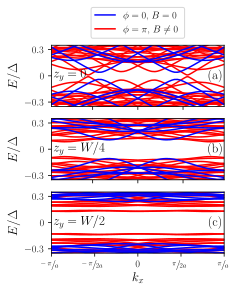

In [38]:
mapping = {(z_y, B_x, phase): learner for (z_y, B_x, phase), learner in zip(combos, learners)}

def plot(ax, key, color):
    data = mapping[key].data
    xs, ys = map(np.array, zip(*sorted(data.items())))
    return ax.plot(xs, ys, c=color)

fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(fig_width/2, fig_height))
(ax1, ax2, ax3) = axs

line2 = plot(ax1, (0, B, np.pi), 'red')[0]
line1 = plot(ax1, (0, 0, 0), 'blue')[0]

plot(ax2, (W/4, B, np.pi), 'red')
plot(ax2, (W/4, 0, 0), 'blue')

plot(ax3, (W/2, B, np.pi), 'red')
plot(ax3, (W/2, 0, 0), 'blue')

for i, ax in enumerate(axs):
    ax.set_ylabel(r'$E/\Delta$')
    
    # ylims and yticks
    ax.set_ylim(-0.35, 0.35)
    yvals = [-0.3, 0, 0.3]
    ylabels = [f'${x}$' for x in yvals]
    ax.set_yticks(yvals)
    ax.set_yticklabels(ylabels)
    
    # xlims and xticks
    ax.set_xlim(-3, 3)
    xvals = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    xlabels = ['$\sfrac{-\pi}{a}$', '$\sfrac{-\pi}{2a}$', r'$0$', '$\sfrac{\pi}{2a}$', r'$\sfrac{\pi}{a}$']
    ax.set_xticks(xvals)
    ax.set_xticklabels(xlabels)

    # text inside image
    label = 'abc'[i]
    ax.text(0.95, 0.5, f'$\mathrm{{({label})}}$', transform=ax.transAxes,
            verticalalignment='center', horizontalalignment='center')
    
    z_ys = ['0', 'W/4', 'W/2']
    ax.text(0.01, 0.5, f'$z_y={z_ys[i]}$', transform=ax.transAxes,
            verticalalignment='center', horizontalalignment='left')

ax1.legend((line1, line2), (r'$\phi=0$, $B=0$', r'$\phi=\pi$, $B \ne 0$'),
           loc='upper center', bbox_to_anchor=(0.5, 1.7),
           fancybox=True, shadow=False, ncol=1)

ax3.set_xlabel('$k_x$')

plt.savefig("thesis_report/figures/bandstructures.pdf", bbox_inches="tight")
plt.show()

# Figure 4. Phase diagrams

TODO:
* add the phase boundaries
* fix the algorithm (something goes wrong when calculating the gap)

### Phase boundaries

In [39]:
# import operator
# from adaptive import Learner1D, make_datasaver
# from statistics import mean

# def phase_boundary_wrapper(B_x, key, z_y, syst_pars=copy(default_syst_pars),
#                            params=copy(default_params), nbands=2000, sigma=0):
#     import numpy as np
#     import sns_system, spectrum
    
#     params = dict(params, B_x=B_x)
#     syst_pars = dict(syst_pars, z_y=z_y, mu_from_bottom_of_spin_orbit_bands=False)
# #     syst_pars['z_x'] = 10 # tmp
# #     syst_pars['L_x'] = 10 # tmp
#     syst_at_k, _, _ = sns_system.make_system(**syst_pars)
#     return spectrum.find_phase_bounds(
#         syst_at_k, params, k_x=0, num_bands=nbands, sigma=sigma)


# W = default_syst_pars['L_m']
# combos = [(0, 'mu', (10, 30)),
# #           (0, 'phase', (0, 2*np.pi)),
#           (W/2, 'mu', (10, 30)),
# #           (W/2, 'phase', (0, 2*np.pi))
# ]

# # Learner = make_datasaver(Learner1D, arg_picker=operator.itemgetter(0))

# learners = [Learner1D(function=partial(phase_boundary_wrapper, key=key, z_y=z_y, sigma=mean(ybounds)),
#                       bounds=(0, 2)) for z_y, key, ybounds in combos]

# learner = adaptive.BalancingLearner(learners, cdims=(['z_y', 'key'], combos), strategy='npoints')

# fnames = [f'data/phase_boundary/phase_boundary_{combo}.pickle' for combo in combos]
# learner.load(fnames)

# runner = adaptive.Runner(learner, lambda l: l.learners[0].npoints > 10000, executor=client)
# runner.live_info()

In [40]:
# def plot(l):
#     import holoviews as hv
#     if l.data:
#         xs, ys = map(np.array, zip(*sorted(l.data.items())))
#         plots = [hv.Scatter((xs, y)) for y in ys.T]
#     else:
#         plots = [hv.Scatter([])]
#     return hv.Overlay(plots).redim(x='B_x', y='mu')

# learner.plot(plotter=plot).select(mu=(10, 20))

In [41]:
# runner.task.print_stack()

### Energy gaps

In [42]:
sp = dict(default_syst_pars, shape='sawtooth', L_m = 200, L_x=1300, L_sc_up=800, L_sc_down=800, a=10)

In [43]:
import operator
from adaptive import Learner2D, make_datasaver

def gap_wrapper(xy, keys, z_y, syst_pars=copy(sp), params=copy(default_params), nbands=1):
    import numpy as np
    import sns_system, spectrum
    from scipy.optimize import brute
    params = dict(params, **dict(zip(keys, xy)))
    syst_pars = dict(syst_pars, z_y=z_y)

    syst_at_k, _, _ = sns_system.make_system(**syst_pars)

    def energies(k_x):
        params['k_x'] = float(k_x)
        return np.abs(spectrum.calc_spectrum(syst_at_k,
            params, k=nbands)[0]).min()

    return brute(energies, ranges=((0, np.pi),), Ns=51, full_output=True)

W = sp['L_m']
combos = [(0, 'mu', (10, 30)), (0, 'phase', (0, 2*np.pi)),
          (W/2, 'mu', (10, 30)), (W/2, 'phase', (0, 2*np.pi))]

Learner = make_datasaver(Learner2D, arg_picker=operator.itemgetter(1))

learners = [Learner(function=partial(gap_wrapper, keys=[key, 'B_x'], z_y=z_y),
                               bounds=[xbounds, (0, 2)])
            for z_y, key, xbounds in combos]

learner = adaptive.BalancingLearner(learners, cdims=(['z_y', 'key'], combos), strategy='npoints')

fnames = [f'data/phase_diagrams/phase_diagram_{combo}.pickle' for combo in combos]
learner.load(fnames)

runner = adaptive.Runner(learner, lambda l: l.learners[0].npoints > 100, executor=client)
runner.live_info()

In [44]:
# runner.start_periodic_saving(dict(fname=fnames), 180)

In [45]:
list(l.npoints for l in learner.learners)

[2235, 10341, 2279, 3124]

In [46]:
# learner.learners[1].plot()#.redim.range(z=(0,1e-2))

In [47]:
from formulas import fermi_velocity, thouless_energy

In [48]:
vf = fermi_velocity(10, 0.02)
thouless_energy(vf, 2000)

0.21680352830119842

### Combined plot

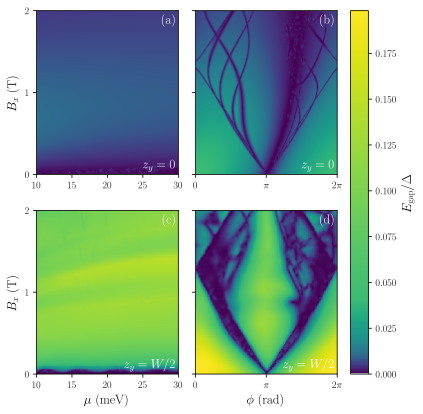

In [49]:
mapping = {(z_y, key): learner for (z_y, key, xbounds), learner in zip(combos, learners)}

E_max = max(max(l.data.values()) for l in learners)

def plot(ax, z_y, key):
    learner = mapping[(z_y, key)]
    im = learner.plot().Image.I
    l, b, r, t = im.bounds.lbrt()

    return ax.imshow(im.data,
                     extent=(l, r, b, t),
                     aspect='auto',
                     cmap='viridis')

fig, axs = plt.subplots(2, 2, sharex=False, sharey=True, figsize=(fig_width, fig_height))
plt.subplots_adjust(bottom=0.2, left=0.125, right=0.80, top=0.8, hspace=0.22, wspace=0.12)
(ax1, ax2), (ax3, ax4) = axs

ims = [plot(ax, z_y, key) for ax, (z_y, key, xbounds) in zip(axs.reshape(-1), combos)]
    

for i, ax in enumerate(axs.reshape(-1)):
    if i in [0, 2]:
        ax.set_ylabel(r'$B_x$ (T)')

    # ylims and yticks
    yvals = [0, 1, 2]
    ylabels = [f'${x}$' for x in yvals]
    ax.set_yticks(yvals)
    ax.set_yticklabels(ylabels)

    # xlims and xticks
    if i in [1, 3]:
        xvals = [0, np.pi, 2*np.pi]
        xlabels = [r'$0$', '$\pi$', r'$2\pi$']
        ax.set_xticks(xvals)
        ax.set_xticklabels(xlabels)

    # text inside image
    label = 'abcd'[i]
    ax.text(0.99, 0.98, f'$\mathrm{{({label})}}$', transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            color='white')

    z_y = ['0', '0', 'W/2', 'W/2'][i]
    ax.text(0.99, 0.01, f'$z_y={z_y}$', transform=ax.transAxes,
            verticalalignment='bottom', horizontalalignment='right',
            color='white')

ax3.set_xlabel('$\mu$ (meV)')
ax4.set_xlabel('$\phi$ (rad)')

im = learners[1].plot().Image.I
norm = HistogramNormalize(im.data, vmin=0, vmax=E_max, mixing_degree=0.6)
for im in ims:
    im.set_norm(norm)

cax = fig.add_axes([0.83, 0.2, 0.04, 0.6])  # [l, b, w, h]
cb = fig.colorbar(ims[3], cax=cax,
                  label=r'$E_{\mathrm{gap}}/ \Delta$')
# cbar_ticks = [0, 5, 10, 15, 20, 25]
# cb.set_ticks(cbar_ticks)

plt.savefig("thesis_report/figures/phasediagrams.pdf", bbox_inches="tight")
plt.show()

# Figure 5. Wavefunctions

TODO: add the Laeven shape and tune the parameters

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


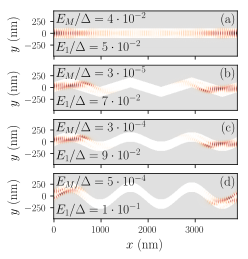

In [51]:
def num_to_latex_exp(x, only_exp=True):
    if not only_exp:
        num, exponent = f'{x:.0e}'.split('e')
        return rf'{num} \cdot 10^{{{int(exponent)}}}'
    else:
        exponent = np.floor(np.log10(np.abs(x))).astype(int)
        return f'10^{{{int(exponent)}}}'

def gist_heat_r_transparent():
    import matplotlib.cm
    import matplotlib.colors as mcolors
    colors = matplotlib.cm.gist_heat_r(np.linspace(0, 1, 128))
    colors[:, 3] = np.linspace(0, 1, 128).tolist()
    gist_heat_r_transparent = mcolors.LinearSegmentedColormap.from_list('gist_heat_r_transparent', colors)
    return gist_heat_r_transparent

def deltas(syst):
    return [np.abs(syst.hamiltonian(i, i, params=params)[1, 0])
            for i, site in enumerate(syst.sites)]

part_to_color =  {'middle_interior' : 'grey',
                  'middle_barrier' : 'black',
                  'bottom_superconductor' : 'gold',
                  'top_superconductor' : 'gold',
                  'top_cut' : 'red',
                  'bottom_cut' : 'blue'}

fig, axs = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(fig_width, fig_height))
(ax1, ax2, ax3, ax4) = axs

shapes = ['parallel_curves',
          'sawtooth',
          'parallel_curves',
          'parallel_curves']  # XXX: last one should be Laeven shape

for i, (ax, shape, z_y) in enumerate(zip(axs, shapes, [0, 100, 100, 180])):
    L_x = 3 * default_syst_pars['z_x']
    syst_pars = dict(default_syst_pars, wraparound=False, z_y=z_y, L_x=L_x, shape=shape)
    syst, site_parts, _ = sns_system.make_system(**syst_pars)
    params = dict(default_params, B_x=1)
    ham = syst.hamiltonian_submatrix(sparse=True, params=params)
    energies, wfs = spectrum.mumps_eigsh(ham, 4, 0)
    wfs = wfs[:, energies > 0]
    energies = energies[energies > 0]
    inds_min = np.argsort(energies)
    rho = kwant.operator.Density(syst)
    
    # text inside image
    label = 'abcd'[i]
    ax.text(0.995, 0.95, f'$\mathrm{{({label})}}$', transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            color='black')
    
    E_M = num_to_latex_exp(np.abs(energies[inds_min[0]]), only_exp=False)
    E_gap = num_to_latex_exp(np.abs(energies[inds_min[1]]), only_exp=False)

    ax.text(0.01, 0.945, rf'$E_M/\Delta={E_M}$',
            transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='left',
            color='black')
    
    ax.text(0.01, 0.02, rf'$E_{{\textrm{{1}}}} / \Delta = {E_gap}$',
            transform=ax.transAxes,
            verticalalignment='bottom', horizontalalignment='left',
            color='black')
    
    ax.set_ylabel('$y$ (nm)')
    
    # Plot the lattice
#     site_colors = [part_to_color[site_parts[s]] for s in syst.sites]
#     site_colors = delta(syst.sites)
#     kwant.plot(syst, site_color=site_colors, ax=ax, site_lw=0)

    # Plot where the normal region is
    Deltas = deltas(syst)
    Deltas = [1 if x == 0 else np.nan for x in Deltas]
    gray_r = matplotlib.cm.gray_r
    gray_r.set_bad('#e0e0e0')
    kwant.plotter.map(syst, Deltas, ax=ax, show=False, cmap=gray_r)
    
    # Plot the wf
    kwant.plotter.map(syst, rho(wfs[:, inds_min[0]]), ax=ax, show=False, cmap=gist_heat_r_transparent())

ax4.set_xlabel('$x$ (nm)')
    
plt.savefig("thesis_report/figures/wavefunctions.pdf", bbox_inches="tight")
plt.show()

# Figure 6: Bandstructure normal SNS system

In [52]:
# syst_pars_sns = dict(default_syst_pars, a=10, z_x=10, L_x=10,
#                      L_m=50, L_sc_up=200, L_sc_down=200,  shape=None)
# def spectrum_wrapper(k_x, B_x, phase, syst_pars=copy(syst_pars_sns),
#                      params=copy(default_params), nbands=10):
#     import numpy as np
#     import sns_system, spectrum
#     params = dict(params, k_x=k_x, B_x=B_x, phase=phase, alpha=40)
#     syst_pars = dict(syst_pars)
#     syst_at_k, _, _ = sns_system.make_system(**syst_pars)
#     energies = spectrum.calc_spectrum(syst_at_k, params, k=nbands)[0]
#     return np.sort(energies)

# def abs_min_log_loss(xs, ys):
#     from adaptive.learner.learner1D import default_loss
#     ys = [np.log(np.abs(y).min()) for y in ys]
#     return default_loss(xs, ys)

# B = 2
# combos = [(0, 0), (B, 0), (0, np.pi), (B, np.pi)]

# learners = [adaptive.Learner1D(partial(spectrum_wrapper, B_x=B_x, phase=phase),
#                                bounds=[-np.pi, np.pi])
#             for B_x, phase in combos]

# learner = adaptive.BalancingLearner(learners, cdims=(['B_x', 'phi'], combos), strategy='npoints')

# # fnames = [f'data/bandstructures/bandstructures_sns_{combo}.pickle' for combo in combos]
# # learner.load(fnames)

# runner = adaptive.Runner(learner, lambda l: l.learners[0].npoints > 4000, executor=client)
# runner.live_info()

In [53]:
# mapping = {(B_x, phase): learner for (B_x, phase), learner in zip(combos, learners)}

# def plot(ax, key, color):
#     data = mapping[key].data
#     xs, ys = map(np.array, zip(*sorted(data.items())))
#     return ax.plot(xs, ys, c=color)

# fig, _axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(2*fig_width, fig_height))
# axs = np.hstack(_axs)
# ax1, ax2, ax3, ax4 = axs

# plot(ax1, (0, 0), 'red')
# plot(ax2, (0, np.pi), 'blue')
# plot(ax3, (B, 0), 'yellow')
# plot(ax4, (B, np.pi), 'green')

# for i, ax in enumerate(axs):
#     ax.set_ylabel(r'$E/\Delta$')
    
# #     # ylims and yticks
#     ax.set_ylim(-1.2, 1.2)
#     yvals = [-1, 0, 1]
#     ylabels = [-1, 0, 1]
#     ax.set_yticks(yvals)
#     ax.set_yticklabels(ylabels)
    
# #     # xlims and xticks
#     ax.set_xlim(-1.5, 1.5)
# #     xvals = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
# #     xlabels = ['$\sfrac{-\pi}{a}$', '$\sfrac{-\pi}{2a}$', r'$0$', '$\sfrac{\pi}{2a}$', r'$\sfrac{\pi}{a}$']
# #     ax.set_xticks(xvals)
# #     ax.set_xticklabels(xlabels)

# #     # text inside image
# #     label = 'abc'[i]
# #     ax.text(0.95, 0.5, f'$\mathrm{{({label})}}$', transform=ax.transAxes,
# #             verticalalignment='center', horizontalalignment='center')
    
# #     z_ys = ['0', 'W/4', 'W/2']
# #     ax.text(0.01, 0.5, f'$z_y={z_ys[i]}$', transform=ax.transAxes,
# #             verticalalignment='center', horizontalalignment='left')

# # ax1.legend((line1, line2), (r'$\phi=0$, $B=0$', r'$\phi=\pi$, $B \ne 0$'),
# #            loc='upper center', bbox_to_anchor=(0.5, 1.7),
# #            fancybox=True, shadow=False, ncol=1)

# # ax3.set_xlabel('$k_x$')

# # plt.savefig("thesis_report/figures/bandstructures.pdf", bbox_inches="tight")
# plt.show()

# Fig. 7: Analytics vs. kwant

In [5]:
import cmath
import math
import operator
from types import SimpleNamespace
import functools

import kwant
import numpy as np
cot = lambda x: 1 / np.tan(x)

def nu_arg(p):
    num = p.E_z * np.exp(1j * p.theta) - 1j * p.alpha * p.k_x
    denom = p.E_z**2 + p.alpha * p.k_x * (p.alpha * p.k_x - 2 * p.E_z * np.sin(p.theta))
    return num / np.sqrt(denom)

def omega(p, j, sign):
    op = {-1: operator.sub,
          +1: operator.add}[sign]
    return 0.25 * op(gamma(p, j), delta(p, j))

def gamma(p, j):
    k = k_j(p, j)
    x = 1j * k * np.tan(p.W * k / 2)
    return (q(p) + x) / (q(p) - x)

def delta(p, j):
    k = k_j(p, j)
    x = 1j * k * cot(p.W * k / 2)
    return (q(p) - x) / (q(p) + x)

def beta(p, sign):
    w_1 = omega(p, 1, sign)
    w_2 = omega(p, 2, sign)
    nu = nu_arg(p)
    beta = np.array([
        [nu * (w_1 - w_2), (w_1 + w_2)],
        [-(w_1 + w_2), nu.conj() * (w_2 - w_1)]
    ])
    return beta

def S(p):
    if isinstance(p, dict):
        p = SimpleNamespace(**p)
    p.E_z = 0.5 * p.mu_B * p.g * p.B
    r_ll = beta(p, +1)
    t_rl = np.exp(-1j * q(p) * p.W) * beta(p, -1)
    t_lr = np.exp(-1j * q(p) * p.W) * beta(p, -1)
    t_rr = np.exp(-2j * q(p) * p.W) * beta(p, +1)

    S = np.block([[r_ll, t_rl],
                  [t_lr, t_rr]])
    return S

def q(p):
    return np.sqrt((2 * p.m_eff / p.hbar**2) * p.mu_n - p.k_x**2)

def k_j(p, j):
    op = {1: operator.sub,
          2: operator.add}[j]
    p.E_z = 0.5 * p.mu_B * p.g * p.B
    sqrt_term = np.sqrt(
        p.E_z**2
        - 2 * p.alpha * p.E_z * np.sin(p.theta) * p.k_x + p.alpha**2 * p.k_x**2)
    k_sq = (2 * p.m_eff / p.hbar**2) * op(p.mu_n, sqrt_term) - p.k_x**2
    return np.sqrt(k_sq)

In [6]:
import scipy.constants
constants = dict(
    m_eff=0.02 * scipy.constants.m_e / (scipy.constants.eV * 1e-3) / 1e18,
    hbar=scipy.constants.hbar / (scipy.constants.eV * 1e-3),
    mu_B=scipy.constants.physical_constants['Bohr magneton'][0] / (
        scipy.constants.eV * 1e-3),
    exp=cmath.exp,
    cos=cmath.cos,
    sin=cmath.sin)

params = dict(g=26, mu_n=20, mu_s=20, alpha=10, B=1, theta=1*np.pi/4, k_x=0.0, W=100, a=1, phi=np.pi, **constants)

k_F = lambda p: np.sqrt(p['mu_n'] * (2 * p['m_eff'])) / p['hbar']

In [7]:
def make_syst(a=params['a'], W=params['W'], transverse_spin_orbit=False):
    ham = ("(0.5 * hbar**2 * (k_x**2 + k_y**2) / m_eff - mu_n) * sigma_0 + "
           "alpha * (k_y * sigma_x - k_x * sigma_y) + "
           "0.5 * g * mu_B * B * (cos(theta) * sigma_x + sin(theta) * sigma_y)")
    if not transverse_spin_orbit:
        ham = ham.replace('k_y * sigma_x', '0*sigma_z')
        
    template = kwant.continuum.discretize(ham, grid_spacing=a)
    template_sc = kwant.continuum.discretize(ham.replace('alpha', '0').replace('mu_B', '0'), grid_spacing=a)
    syst = kwant.Builder(kwant.TranslationalSymmetry([a, 0]))
    trs = 1j * np.array([[0, -1j],[1j, 0]])
    lead = kwant.Builder(kwant.TranslationalSymmetry([a, 0], [0, a]), time_reversal=trs)
    syst.fill(template, lambda s: 0 <= s.pos[1] < W, (0, 0))
    syst = kwant.wraparound.wraparound(syst)
    lead.fill(template_sc, lambda s: True, (0, 0))
    lead = kwant.wraparound.wraparound(lead, keep=1)
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    return syst.finalized()

syst_w_soi = make_syst(transverse_spin_orbit=True)
syst_wo_soi = make_syst(transverse_spin_orbit=False)

In [8]:
def energy_operator(syst, params):
    params = dict(params, cos=math.cos, sin=math.sin)
    
    if syst is None:
        smatrix = lambda syst, params: S(params)
    else:
        smatrix = lambda syst, params: kwant.smatrix(syst, params=params).data
    
    if params['k_x'] == 0:
        smat_plus = smat_min = smatrix(syst, params)
    else:
        params['k_x'] *= -1
        smat_min = smatrix(syst, params)
        params['k_x'] *= -1
        smat_plus = smatrix(syst, params)

    phase = cmath.exp(1j * params['phi'] / 2)
    r = np.diag([phase, phase, phase.conjugate(), phase.conjugate()])
    smat_prod = r @ smat_min.conj() @ r.conj() @ smat_plus
    return smat_prod

def energies_over_delta(syst, params):
    """Same as energy_operator(), but returns the
    square-root of the eigenvalues"""
    try:
        from numpy.lib.scimath import sqrt
        operator = energy_operator(syst, params)
        es = -1/np.linalg.eigvals(operator)
        alpha = np.hstack([sqrt(es), -sqrt(es)])
        E = alpha[alpha.imag >= 0].real
        return np.sort(E)
    except Exception as e:
        print(e)
        return np.array(4*[np.nan])

In [9]:
syst_pars_sns = dict(default_syst_pars, a=params['a'], z_x=params['a'], L_x=params['a'],
                     L_m=params['W'], L_sc_up=1600, L_sc_down=1600,  shape=None)
params_sns = dict(default_params, g_factor_middle=params['g'], mu=params['mu_n'],
                  B_x=params['B']*np.cos(-params['theta']), B_y=params['B']*np.sin(-params['theta']),
                  phase=params['phi'], alpha_middle=params['alpha'],Delta_left=1, Delta_right=1)
    
syst_at_k, _, _ = sns_system.make_system(**syst_pars_sns)

def spectrum_wrapper(k_x, syst_pars=copy(syst_pars_sns),
                     params=copy(default_params), nbands=4):
    import numpy as np
    import sns_system, spectrum
    params_local = dict(params_sns, k_x=k_x)

    energies = spectrum.calc_spectrum(syst_at_k, params_local, k=nbands)[0]
    return np.sort(energies)

/home/tinkerer/thesis_repo/two_dim_majoranas/sns_system.py:414: RuntimeWarning: fill(): None of the starting sites is in the desired shape
  edge_sites_new = syst.fill(template_edge, edge_shape, pos)


In [10]:
def calc_kwant_scatter_wo_soi(k):
    return energies_over_delta(syst_wo_soi, dict(params, k_x=k*params['a']))

def calc_kwant_scatter_w_soi(k):
    return energies_over_delta(syst_w_soi, dict(params, k_x=k*params['a']))

def calc_analytic_scatter(k):
    return energies_over_delta(None, dict(params, k_x=k))

def calc_kwant_full(k):
    return spectrum_wrapper(k_x=k*params['a'])/params_sns['Delta_left']

k_F = lambda p: np.sqrt(p['mu_n'] * (2 * p['m_eff'])) / p['hbar']
kmax = 1.2*k_F(params)

l_kwant_scatter_wo_soi = adaptive.Learner1D(calc_kwant_scatter_wo_soi, [-kmax, kmax], loss_per_interval=adaptive.learner.learner1D.uniform_loss)
l_kwant_scatter_w_soi = adaptive.Learner1D(calc_kwant_scatter_w_soi, [-kmax, kmax], loss_per_interval=adaptive.learner.learner1D.uniform_loss)
l_analytic_scatter = adaptive.Learner1D(calc_analytic_scatter, [-kmax, kmax], loss_per_interval=adaptive.learner.learner1D.uniform_loss)
l_kwant_full = adaptive.Learner1D(calc_kwant_full, [-kmax, kmax], loss_per_interval=adaptive.learner.learner1D.uniform_loss)

lnames = ['Kwant_without_SOI_SJL',
         'Kwant_with_SOI_SJL',
         'Analytic_solution_SJL',
         'Full_1D_kwant_system']
bl = adaptive.BalancingLearner([l_kwant_scatter_wo_soi, l_kwant_scatter_w_soi, l_analytic_scatter, l_kwant_full], strategy='npoints')
fnames = [f'data/spectrum_calculation_comparison/spectrum_calculation_comparison_{lname}.pickle' for lname in lnames]
bl.load(fnames)

In [11]:
# bl.save(fnames)

In [12]:
# runner = adaptive.Runner(bl)
# runner.live_info()

In [13]:
def remove_steps(data, threshold=1):
    xs = np.sort(np.array(list(data.keys())))
    ys = np.vstack([data[key] for key in xs])

    dys = np.diff(ys, axis=0)
    threshold = 1e-1
    ys2 = ys.copy()

    for idx, dy in enumerate(dys):
        if max(abs(dy)) > threshold:
            yl = ys[idx, :]
            yr = ys[idx+1, :]

            dy_arr = np.abs(yl[np.newaxis, :].T - yr)
            indices = np.argmin(dy_arr, 1)
            ys2[idx, indices] = np.nan
#             print(xs[idx], max(abs(dy)), dy.shape, indices)
            ys2[idx+1, :] = 4*[np.nan]#yr[indices]
    return (xs, ys2)

In [14]:
x1, y1 = remove_steps(l_kwant_scatter_w_soi.data)
x2, y2 = remove_steps(l_kwant_scatter_wo_soi.data)
x3, y3 = remove_steps(l_analytic_scatter.data)
x4, y4 = remove_steps(l_kwant_full.data)

In [15]:
import holoviews as hv
hv.Path((x1, y1))*hv.Path((x2, y2))*hv.Path((x3, y3))*hv.Path((x4, y4))

:Overlay
   .Path.I   :Path   [x,y]
   .Path.II  :Path   [x,y]
   .Path.III :Path   [x,y]
   .Path.IV  :Path   [x,y]

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


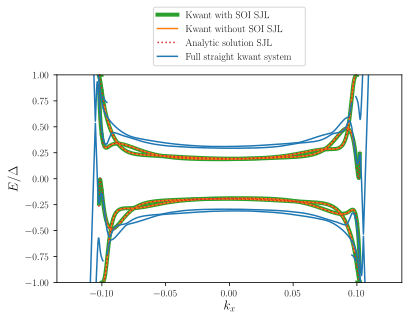

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
l1,_,_,_ = ax.plot(x1, y1, 'C2', linewidth=4);
l2,_,_,_ = ax.plot(x3, y3, 'C1');
l3,_,_,_ = ax.plot(x2, y2, 'C3:');
l4,_,_,_ = ax.plot(x4, y4, 'C0-');
ax.legend([l1,l2,l3,l4],['Kwant with SOI SJL',
                         'Kwant without SOI SJL',
                         'Analytic solution SJL',
                         'Full straight kwant system'], loc='upper center', bbox_to_anchor=(0.5, 1.35),
           fancybox=True, shadow=False, ncol=1)
ax.set_ylim(-1, 1);
ax.set_ylabel(rf'$E/\Delta$')
ax.set_xlabel(rf'$k_x$')

plt.savefig('thesis_report/figures/spectrum_calculation_comparison.pdf', bbox_inches="tight")

# Figure 2. E_gap(z_y)

## Complete zigzag system

### System size examples

### Define learners

In [5]:
# import operator
# from adaptive.learner.learner1D import curvature_loss_function

# def gap_wrapper(k_x, z_y, ratio, syst_pars=copy(default_syst_pars), params=copy(default_params), nbands=10):
#     import numpy as np
#     import sns_system, spectrum
#     z_x = z_y * ratio
#     params = dict(params, k_x=k_x, mu=40, B_x=1)
#     syst_pars = dict(syst_pars, z_y=z_y, z_x=z_x, L_x=z_x,
#                      a=5, shape='sawtooth', L_sc_up=800, L_sc_down=800)
#     syst_at_k, _, _ = sns_system.make_system(**syst_pars)
#     Es = spectrum.calc_spectrum(syst_at_k, params, k=nbands)[0]
#     return dict(E_min=np.abs(Es).min(), energies=Es)

# def fnames(learner):
#     val = learner.function.keywords  # because functools.partial
#     fname = '__'.join([f'{k}_{v}.pickle' for k, v in val.items()])
#     return 'data/z_y_vs_E_gap_mu40meV/' + fname

# Learner = adaptive.make_datasaver(adaptive.Learner1D, arg_picker=operator.itemgetter('E_min'))
# kwargs = dict(bounds=[-np.pi, np.pi], loss_per_interval=curvature_loss_function())
# z_ys = np.arange(10, 405, 5)
# combos = {'z_y': z_ys, 'ratio': [4, 8, 16]}
# learner = adaptive.BalancingLearner.from_product(gap_wrapper, Learner, kwargs, combos)
# learner.strategy = 'npoints'
# learner.load(fnames)

In [7]:
# runner = adaptive.Runner(learner, lambda l: l.loss() < 0.0001, executor=client,
#                          retries=20, raise_if_retries_exceeded=False)
# runner.live_info()

In [8]:
# saving_task = runner.start_periodic_saving(dict(fname=fnames), 600)

In [10]:
# # Plot the entire band structure
# def plot_bands(l):
#     import holoviews as hv
#     if l.data:
#         ks, vals = zip(*l.extra_data.items())
#         Es = np.array([x['energies'] for x in vals])
#         E_min = min(l.data.values())
#         scatter = hv.Overlay([hv.Scatter((ks, E)).opts(style=dict(color='k')) for E in Es.T])
#         return scatter * hv.HLine(E_min)
#     else:
#         return hv.Overlay(hv.Scatter([]))

# learner.plot(plotter=plot_bands)

In [12]:
# from collections import defaultdict
# d = defaultdict(dict)
# for cdim, l in zip(learner._cdims_default, learner.learners):
#     d[cdim['ratio']][cdim['z_y']] = l

# def get_mins(learners_dict):
#     learners = learners_dict.values()
#     return [min(l.data.values()) for l in learners]

# # fig, ax = plt.subplots()
# # for ratio, val in d.items():
# #     E_gaps = get_mins(val)
# #     ax.plot(z_ys, E_gaps, label=f'ratio {ratio}')
# # ax.legend()
# # ax.set_xlabel('$z_y$ (nm)')
# # ax.set_ylabel(r'$E_{\textrm{gap}}$ (meV)')
# # plt.savefig('paper/figures/z_y_vs_E_gap.pdf')
# # plt.show()

In [13]:
# import pickle
# with open('tmp.pickle', 'wb') as f:
#     E_gaps = {ratio: get_mins(val) for ratio, val in d.items()}
#     pickle.dump([z_ys, E_gaps], f)

## Quasi classical system

In [19]:
# # "quasi classics"
# a = 4
# syst_pars = dict(
#     default_syst_pars,
#     L_sc_up=1600,
#     L_sc_down=1600,
#     L_x=a,
#     z_x=a,
#     a=a,
#     shape=None,
#     mu_from_bottom_of_spin_orbit_bands=False
# )

# params = dict(default_params, B=1, mu=40)

# def bands(k_x, ratio, params=params, syst_pars=syst_pars):
#     syst = sns_system.make_system(**syst_pars)[0]
#     theta = np.arctan(4 / ratio)
#     params = dict(params,
#                   theta=theta,
#                   B_x=np.cos(theta)*params['B'],
#                   B_y=np.sin(theta)*params['B'],
#                   k_x=k_x*a)
#     return np.min(np.abs(spectrum.calc_spectrum(syst, params, k=4)[0]))

# ratios = [4, 8, 16]
# k_F = np.sqrt(params['mu'] * (2 * params['m_eff'])) / params['hbar']
# loss = adaptive.learner.learner1D.triangle_loss

# learner = adaptive.BalancingLearner.from_product(
#     bands,
#     learner_type=adaptive.Learner1D,
#     learner_kwargs=dict(bounds=[0, 1.1*k_F], loss_per_interval=loss),
#     combos=dict(ratio=ratios))
# learner.strategy = 'npoints'

In [63]:
# runner = adaptive.Runner(learner, goal=lambda l: l.loss() < 1e-5)
# runner.live_info()

In [62]:
# learner.plot()

In [64]:
# from types import SimpleNamespace
# from scipy.optimize import minimize_scalar
# from scipy.misc import derivative

# def energies(k_y, params):
#     p = SimpleNamespace(**params)
#     g = p.g_factor_middle
#     alpha = p.alpha_middle
#     E_z = 0.5 * g * p.mu_B * p.B
#     sqrt_term = np.sqrt(
#         + E_z**2
#         + alpha * (2 * E_z * (k_y * np.cos(p.theta) - p.k_x * np.sin(p.theta))
#                    + alpha * (p.k_x**2 + k_y**2))
#     )
#     term = p.hbar**2 * (p.k_x**2 + k_y**2) / (2 * p.m_eff) - p.mu
#     return [-sqrt_term + term, sqrt_term + term]

# def find_k_ys(params):
#     f = lambda k_y, i: abs(energies(k_y, params)[i])
#     return [minimize_scalar(f, args=i, bounds=[0, np.pi], method='bounded')['x']
#             for i in [0, 1]]

# def find_dE_dkys(k_ys, params):
#     f = lambda k_y, params, i: energies(k_y, params)[i]
#     return [derivative(f, k_y, dx=1e-6, args=[params, i])
#             for i, k_y in enumerate(k_ys)]

# def find_dE_dkxs(k_ys, params):
#     def _f(k_x, k_y, params, i):
#         params['k_x'] = float(k_x)
#         return energies(k_y, params)[i]
#     return [derivative(_f, params['k_x'], dx=1e-6, args=[k_y, copy(params), i])
#             for i, k_y in enumerate(k_ys)]

# def tan_a(params):
#     k_ys = find_k_ys(params)
#     dE_dkx = find_dE_dkxs(k_ys, params)
#     dE_dky = find_dE_dkys(k_ys, params)
#     return np.array(dE_dky) / np.array(dE_dkx)

# def a_min(z_x, z_y, W, *, correction=True):
#     theta = np.arctan(4 * z_y / z_x)
#     crossing_point = W / np.cos(theta)
#     if z_y < crossing_point / 2:
#         return np.nan
#     a = z_x / 2
#     b = z_y * 2
#     c = np.sqrt(W**2 + (b/a)**2 * W**2)
    
#     if correction:
#         D = np.sqrt(a**2 + (b - c)**2)
#     else:
#         D = np.sqrt(a**2 + (b + c)**2)
#     xprime = np.sqrt(D**2 - W**2)
#     return W / xprime

# def get_cutoff(z_x, z_y, W, params):
#     a_m = a_min(z_x, z_y, W)
    
#     k_F = np.sqrt(params['mu'] * (2 * params['m_eff'])) / params['hbar']
    
#     def f(k_x):
#         params['k_x'] = k_x
#         return abs(np.min(tan_a(params)) - a_m)

#     k_c, e = scipy.optimize.fmin(f, k_F/2, ftol=1e-7, xtol=1e-6, full_output=1, disp=0)[:2]
#     return k_c if e < 1e-3 else np.inf

In [58]:
# def get_gaps(z_ys, learner, ratio, syst_pars=syst_pars):
#     ks, Es = zip(*sorted(learner.data.items()))
#     W = syst_pars['L_m']
#     params['theta'] = np.arctan(4 / ratio)
#     k_max_at_z_y = np.array([get_cutoff(ratio*z_y, z_y, W, params) for z_y in z_ys])
#     E_gaps = np.interp(k_max_at_z_y, ks, np.minimum.accumulate(Es, 0))
#     return E_gaps

# z_ys = np.linspace(100, 400, 100)
# data = {cdim['ratio']: get_gaps(z_ys, l, cdim['ratio'])
#         for cdim, l in zip(learner._cdims_default, learner.learners)}

In [59]:
# data_new = {}
# for ratio, gaps in data.items():
#     gaps_n = gaps
#     idx = np.where(gaps_n>1e-2)[0][0]
#     gaps_n[:idx]= np.nan
#     data_new[ratio] = gaps_n
    
# data = data_new

In [60]:
# fig, ax = plt.subplots()
# for ratio, E_gaps in data_new.items():
#     ax.plot(z_ys, E_gaps, label=f'ratio {ratio}, QC')

    
# ax.legend()
# ax.set_xlabel('$z_y$ (nm)')
# ax.set_ylabel(r'$E_{\textrm{gap}}$ (meV)')
# plt.savefig('paper/figures/z_y_vs_E_gap2.pdf')
# plt.show()

In [61]:
# import pickle
# with open('tmp_quasi.pickle', 'wb') as f:
#     pickle.dump([z_ys, data_new], f)

In [7]:
import pickle
with open('data/qc/tmp.pickle', 'rb') as f:
    z_ys_complete, E_gaps_complete = pickle.load(f)
    
with open('data/qc/tmp_quasi.pickle', 'rb') as f:
    z_ys_quasi, E_gaps_quasi = pickle.load(f)

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


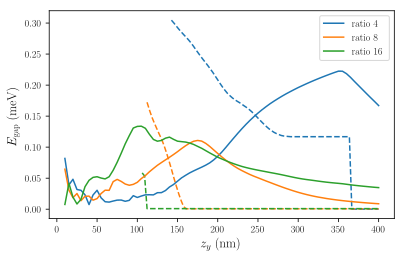

In [13]:
fig, ax = plt.subplots(figsize = fig_size)

col = {4: 'C0', 8: 'C1', 16: 'C2'}

for ratio, E_gaps in E_gaps_quasi.items():
    ax.plot(z_ys_quasi, E_gaps, ls='--', c=col[ratio])

for ratio, E_gaps in E_gaps_complete.items():
    ax.plot(z_ys_complete, E_gaps, c=col[ratio], label=f'ratio {ratio}')
    
ax.legend()
ax.set_xlabel('$z_y$ (nm)')
ax.set_ylabel(r'$E_{\textrm{gap}}$ (meV)')
plt.savefig('thesis_report/figures/z_y_vs_E_gap.pdf')
plt.show()

# Bandstructures

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


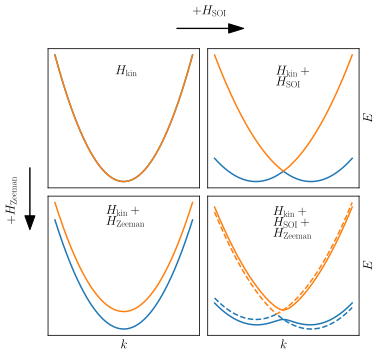

In [12]:
kx = np.linspace(-2.5, 2.5, 200)
Ekin = lambda k: np.array(k)**2
Esoi = lambda k, alpha: np.array([(np.array(k)+alpha)**2, (np.array(k)-alpha)**2]).T
Ezm_x  = lambda k, Ez: np.array([np.array(k)**2 - Ez, np.array(k)**2 + Ez]).T
Ezm_y  = lambda k, Ez: np.array([np.array(k)**2 - Ez, np.array(k)**2 + Ez]).T
def Hzsoi(k, alpha, Ez):
    return np.array([[k**2, -1j*k*alpha + Ez], [1j*k*alpha + Ez, k**2]])

def Hzsoi(k, alpha, Ez_x, Ez_y, Ez_z):
    return np.array([[k**2 + Ez_z, -1j*k*alpha + Ez_x -1j*Ez_y], [1j*k*alpha + Ez_x + 1j*Ez_y, k**2 - Ez_z]])

def Ezsoi(k, alpha, Ez_x, Ez_y, Ez_z):
    return [np.linalg.eigvalsh(Hzsoi(_k, alpha, Ez_x, Ez_y, Ez_z)) for _k in k] 

tick_opts = {'axis': 'both', 'bottom':False, 'left':False, 'labelbottom':False, 'labelleft':False}
fig, axs_mat = plt.subplots(2, 2, figsize=(.5*1.5*1*fig_width, .5*1.5*1.5*fig_height))
axs_list = (*axs_mat[0], *axs_mat[1])
ax0, ax1, ax2, ax3 = axs_list

ax0.plot(kx, Ezsoi(kx, 0, 0, 0, 0), label=rf'kinetic');
ax1.plot(kx, Ezsoi(kx, 2, 0, 0, 0), label=rf'kinetic');
ax2.plot(kx, Ezsoi(kx, 0, .5, 0, 0), label=rf'kinetic');
ax3.plot(kx, Ezsoi(kx, 2, .5, 0, 0), label=rf'kinetic');
ax3.set_prop_cycle(None) 
ax3.plot(kx, Ezsoi(kx, 2, .0, .5, 0),'--', label=rf'kinetic');

[ax.tick_params(**tick_opts) for ax in axs_list];
[ax.set_xlabel('$k$')  for ax in [ax2, ax3]];
[ax.set_ylabel('$E$')  for ax in [ax3, ax1]];
[ax.yaxis.set_label_position('right')  for ax in axs_list];

pt_top_left = np.array([.4, 1.05])
pt_top_right = np.array([.6, 1.05])

pt_left_top = np.array([-0.04, .6])
pt_left_bottom = np.array([-0.04, .4])

arrow = matplotlib.patches.FancyArrow(
    pt_top_left[0], pt_top_left[1], pt_top_right[0]-pt_top_left[0], pt_top_right[1]-pt_top_left[1],
    transform=fig.transFigure, width=0.001, length_includes_head=True, head_width=0.03, color='k')

fig.text((pt_top_left + pt_top_right)[0]/2, (pt_top_left + pt_top_right)[1]/2 + .05, r'$+ H_\text{SOI}$', ha='center', va='center')

arrow2 = matplotlib.patches.FancyArrow(
    pt_left_top[0], pt_left_top[1], pt_left_bottom[0]-pt_left_top[0], pt_left_bottom[1]-pt_left_top[1],
    transform=fig.transFigure, width=0.001, length_includes_head=True, head_width=0.03, color='k')

fig.text((pt_left_top + pt_left_bottom)[0]/2-.05, (pt_left_top + pt_left_bottom)[1]/2, r'$+ H_\text{Zeeman}$', va='center', ha='center', rotation='vertical')

# fig.text(-.05, 1.05, r'$H_\text{kin}$', va='center', ha='center')
fig.text(.25, .925, r'\noindent$H_\text{kin}$', va='top', ha='center')
fig.text(.75, .925, r'\noindent$H_\text{kin} + \\H_\text{SOI}$', va='top', ha='center')
fig.text(.25, .475, r'\noindent$H_\text{kin} + \\H_\text{Zeeman}$', va='top', ha='center')
fig.text(.75, .475, r'\noindent$H_\text{kin} + \\H_\text{SOI}+ \\H_\text{Zeeman}$', va='top', ha='center')


# 5. Add patch to list of objects to draw onto the figure
fig.patches.append(arrow)
fig.patches.append(arrow2)

fig.tight_layout(pad=0.1)
plt.savefig('thesis_report/figures/simple_terms.pdf', bbox_inches='tight')
plt.show()